In [1]:

'''

IMPORTS

'''
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import ast
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, find_peaks, correlate, gaussian, filtfilt
from scipy import stats
from scipy import signal
from scipy import stats
from scipy import signal
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import McsPy
import McsPy.McsData
from McsPy import ureg, Q_
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import scipy
import time
import glob
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import copy
import pickle
import fnmatch

# Plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
#networkx
import plotly.graph_objects as go
import networkx as nx
import matplotlib.patches as mpatche





'''

FUNCTIONS

'''


def invert_layerdic(layer_dic):
    
    '''
    Expects a dictionary with key = layer, value = list of channellabels
    
    Returns a dictionary with key = channellabels, value = layer
    '''
    layerdic_invert = {}

    for key in layer_dic:
        for i in layer_dic[key]:
            layerdic_invert[i]=key
            
            
    return layerdic_invert



def remove_artefact_spikes(spikes, recording_length, tick, scale_factor_for_second, window=0.01):
    
    removing_times = []
    i = 0
    removed_spikes = {} 
    kicked_out = {}
    while i < recording_length:
        activechannels = 0
        for key in spikes:
            for s in spikes[key]:
                if i <= s*tick*scale_factor_for_second < (i + window):
                    activechannels += 1
        if activechannels >= 100:
            removing_times.append(i)
        i += window

    
    print(removing_times)
    for key in spikes:
        new_spikes = []
        kicked_out_list = []

        s_list_save = list(spikes[key])
        s_list = list(spikes[key])
        for s in s_list_save:
            for time in removing_times:
                if time <= s*tick*scale_factor_for_second < (time + window*2):
                    kicked_out_list.append(s)
                    try:
                        s_list.remove(s)
                    except ValueError:
                        pass
                #else:
                 #   new_spikes.append(s)
        removed_spikes[key] = s_list
        kicked_out[key] = kicked_out_list

    return removed_spikes, kicked_out




def gaussian_smoothing(y, window_size=10, sigma=500):

    filt = signal.gaussian(window_size, sigma)

    return signal.convolve(y, filt, mode='same')



def bin_spike_dictionary(spike_dic_sec, bin_length_ms, recording_length_sec):
    
    binned_spikedic_sec = {}
    
    # get the number of needed bins
    number_of_bins = int(recording_length_sec / (bin_length_ms*0.001))
    
    
    for key in spike_dic_sec:
        binned = np.histogram(spike_dic_sec[key], bins = number_of_bins, range= (0, recording_length_sec))
        binned_spikedic_sec[key] = binned[0]
    
    return binned_spikedic_sec






def find_shared_spiking_activity(binned_spikedic):
    
    spike_connection_dic = {}
    spike_connection_dic_simple = {}

    
    for key in binned_spikedic:
        other_keys = list(binned_spikedic.keys())
        other_keys.remove(key)
        connections = []
        connections_simple = []
        

        for j in other_keys: 
            
            number_shared = 0
            for i in binned_spikedic[key]:
                if i > 0:
                    if binned_spikedic[j][i] > 0:
                        number_shared += 1
                
            if number_shared > 0:
                connections.append((j, number_shared))
                connections_simple.append(j)

        spike_connection_dic[key] = connections
        spike_connection_dic_simple[key] = connections_simple

        

    return spike_connection_dic, spike_connection_dic_simple



def get_dict_values(df, dic):
    
    for i in df.columns:
        for j in range(0, 16):
            keystring = i+str(df.index[j])
            #print(keystring)
            if keystring in dic.keys():
                df.loc[df.index[j],i]=dic[keystring]
            
                
    
    return df



all_channels = ['D1', 'E1', 'F1', 'G1', 'H1', 'J1', 'J2', 'K1', 'K2', 'L1', 'L2', 'L3', 'M1', 'M2', 
                    'M3', 'M4', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 
                    'O7', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'R2', 'R3', 'R4', 'R5', 
                    'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'B1', 'B2', 'C1', 'C2', 'D2', 'E2', 'F2', 'G2', 'G3', 'H2', 'H3', 'J3', 'K3', 'K4', 
                     'L4', 'L5', 'M5', 'M6', 'M7', 'N7', 'N8', 'O8', 'O9', 'O10', 'O11', 'P10', 'P11', 
                     'P12', 'P13', 'P14', 'P15', 'P16', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'B3', 'B4', 'B5', 'B6', 
                     'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                      'C11', 'C12', 'C13', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 
                     'D13', 'D14', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 
                     'E15', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 
                     'F16', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 
                     'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'J4', 
                     'J5', 'J6', 'J7', 'J8', 'J9', 'J10', 'J11', 'J12', 'J13', 'J14', 'J15', 'J16', 'K5', 'K6', 
                     'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'L6', 'L7', 'L8', 'L9', 
                     'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 
                     'M14', 'M15', 'M16', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O12', 'O13', 
                     'O14', 'O15', 'O16', 'A12', 'A13', 'A14', 'A15', 'B13', 'B14', 'B15', 'B16', 'C14', 'C15', 'C16', 'D15', 'D16', 'E16']





hier die inputdirectory anpassen

In [2]:
inputdirectory = '/Users/jonas/Documents/DATA/MEA_DATA_Aachen_sample/output/2021-05-17_cortex_div11_aCSF_ID046_30µMNE_spont_1'
os.chdir(inputdirectory)
filelist = glob.glob('*.pkl')

hier das mapping dicitonary anpassen

In [20]:
# als key kann alles verwendet werden, z.B. Tumornah/fern...

layerdic = { 
	'tumor_nah':["O1","O2","P1","P2","R2",],
	'tumor_fern':["A2","A3","A4","A5","A6","A7","A8","A9","A15","B1","B2","B3","B4","B5","B6","B7","B8","B9","C1","C2","C3","C4","C5","C6","C7","C8","C9","D1","D2","D3","D4","D5","D6","D7","D8","D9","E1","E2","E3","E4","E5","E6","E7","E8","E9","F1","F2","F3","F4","F5","F6","F7","F8","F9","F10","G1","G2","G3","G4","G5","G6","G7","G8","G9","G10","H1","H2","H3","H4","H5","H6","H7","H8","H9","H10","H11","J1","J2","J3","J4","J5","J6","J7","J8","J9","J10","J11","K1","K2","K3","K4","K5","K6","K7","K8","K9","K10","K11","L2","L3","L4","L5","L6","L7","L8","L9","L10","L11","M2","M3","M4","M5","M6","M7","M8","M9","M10","M11","M12","N2","N3","N4","N5","N6","N7","N8","N9","N10","N11","N12","O3","O4","O5","O6","O7","O8","O9","O10","O11","O12","P3","P4","P5","P6","P7","P8","P9","P10","P11","P12","P13","R3","R4","R5","R6","R7","R8","R9","R10","R11","R12","R13",],
}


In [4]:
print(filelist)
df_list = []
for i in filelist:
    filename = i
    filename = i.split('Dictionary_')[1].split('.pkl')[0]

    print('Working on ' + filename)
    print('this is element ' + str(filelist.index(i)) + ' of ' + str(len(filelist)))


    #create the outputdirectory
    mainoutputdirectory = os.path.join(inputdirectory, 'output_graph')
    outputdirectory = os.path.join(mainoutputdirectory, filename)
    try:
        Path(outputdirectory).mkdir(parents=True, exist_ok=False)
    except FileExistsError:
        pass



    '''
    all basic parameters are imported
    '''
    MAIN_RECORDING_DICTIONARY = pickle.load(open('MAIN_RECORDING_Dictionary_'+filename+'.pkl', "rb"))
    spikedic_MAD = MAIN_RECORDING_DICTIONARY['spikedic_MAD']
    tick = MAIN_RECORDING_DICTIONARY['Infos_Recording']['tick']
    timelengthrecording_s = MAIN_RECORDING_DICTIONARY['Infos_Recording']['timelengthrecording_s']
    info_dics_subrecordings = MAIN_RECORDING_DICTIONARY['Infos_Recording']['info_dics_subrecordings']
    Infos_Recording = MAIN_RECORDING_DICTIONARY['Infos_Recording']
    key_timepoint = list(info_dics_subrecordings.keys())[0]
    first_recording_timepoint = info_dics_subrecordings[key_timepoint]['first_recording_timepoint']
    subrec_infos = info_dics_subrecordings[key_timepoint]
    scale_factor_for_second = MAIN_RECORDING_DICTIONARY['Infos_Recording']['scale_factor_for_second']
    relevant_factor = timelengthrecording_s*0.05
    fr_dic = MAIN_RECORDING_DICTIONARY['fr_dic']

    '''
    removal of artefacts
    '''

    spikedic_MAD, kicked_out = remove_artefact_spikes(spikes=spikedic_MAD, 
                                                      recording_length=timelengthrecording_s, 
                                                      tick=tick,
                                                      scale_factor_for_second=scale_factor_for_second)

    active_channels = 0
    spikedic_seconds = {}
    for key in spikedic_MAD:
        sec_array = np.asarray(spikedic_MAD[key])*tick*scale_factor_for_second
        spikedic_seconds[key]=sec_array
        active_channels += 1

    spikearray_seconds = np.asarray(list(spikedic_seconds.values()))  


    '''
    get one-dimensional array of every detected spike
    '''
    scale_factor_for_milisecond = 1e-03
    full_spike_list = []
    full_spike_list_seconds = []
    for key in spikedic_MAD:
        # without the relevant factor --every channel will be plotted
        x = list(np.asarray(spikedic_MAD[key])*scale_factor_for_milisecond*tick)
        full_spike_list = full_spike_list + x

        xs = list(np.asarray(spikedic_MAD[key])*scale_factor_for_second*tick)
        full_spike_list_seconds = full_spike_list_seconds + xs
    full_spikes = sorted(full_spike_list)
    full_spikes_seconds = sorted(full_spike_list_seconds)

    mean_fr_whole_recording = np.around((len(full_spikes_seconds) / timelengthrecording_s), 3)



    #define bins 
    binsize = 0.005 #seconds
    #bins= np.arange(0, timelengthrecording_s+binsize, binsize)

    #trial of population burst plot as inspired by Andrea Corna
    bins = int(timelengthrecording_s / binsize)+1

    firing_rate_histogram = np.histogram(full_spikes_seconds, bins=bins)
    firing_rate = firing_rate_histogram[0]*200 #conversion to hertz
    #firing_rate = firing_rate_histogram[0]




    # using firing rate histogram already conversed to hertz
    N = int(1/binsize) # für eine Sekunde, das Sliding window, also letztlich number of bins
    plot_N = int(0.01/binsize)
    # gaussian smmothing fo the firing rate and moving average
    fr_gau = gaussian_smoothing(firing_rate)
    plot_fr_gau = gaussian_smoothing(firing_rate)
    ma_fr_gau = np.convolve(fr_gau, np.ones(N)/N, mode='full')
    plotting_ma_fr_gau = np.convolve(fr_gau, np.ones(plot_N)/plot_N, mode='full')

    # we look for the mean of the MA as threshold
    # we arrange this mean in an array for plotting
    mean_ma_fr_gau = np.mean(ma_fr_gau)
    std_ma_fr_gau = np.std(ma_fr_gau)
    network_burst_threshold = mean_ma_fr_gau
    shape_for_threshold = np.shape(ma_fr_gau)
    network_burst_threshold_array = np.full(shape_for_threshold, network_burst_threshold)


    '''
    PLOTTING OF THE corrected Rasterplot
    '''

    fig = plt.figure(figsize = (10,6))
    gs = fig.add_gridspec(2, hspace = 0, height_ratios=[2,5])
    axs = gs.subplots(sharex=False, sharey=False)
    axs[0].plot(ma_fr_gau, color= 'black', lw= 0.5)
    axs[0].set_ylabel('Firing Rate [Hz]')
    axs[0].set_ylim(0, 5000)
    axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,
                     linelengths = 1, colors = 'black')
    axs[1].set_ylabel('Relevant Channels')
    fig.suptitle(filename)

    #for ax in axs:
    #    for i in bursts_seconds:
    #        axs[1].axvspan(i[0], i[1], facecolor = '#5B89A6', alpha = 0.3)


    fig.savefig(os.path.join(outputdirectory, filename+'__raster_firingrate_plot_solo.png'), dpi = 300, bbox_inches='tight')
    fig.savefig(os.path.join(outputdirectory, filename+'__raster_firingrate_plot_solo.png'), dpi = 300, bbox_inches='tight')
    plt.close(fig)

['MAIN_RECORDING_Dictionary_2021-05-17_cortex_div11_aCSF_ID046_30µMNE_spont_1.pkl']
Working on 2021-05-17_cortex_div11_aCSF_ID046_30µMNE_spont_1
this is element 0 of 1


'\n    all basic parameters are imported\n    '

'\n    removal of artefacts\n    '

[62.53999999999613, 62.83999999999607, 76.4400000000022, 106.59000000001762, 113.36000000002109, 113.3700000000211, 118.99000000002397]


'\n    get one-dimensional array of every detected spike\n    '

'\n    PLOTTING OF THE corrected Rasterplot\n    '

Text(0, 0.5, 'Firing Rate [Hz]')

(0.0, 5000.0)

Text(0, 0.5, 'Relevant Channels')

Text(0.5, 0.98, '2021-05-17_cortex_div11_aCSF_ID046_30µMNE_spont_1')

In [21]:


inverted_layerdic = invert_layerdic(layerdic)

Infos_Anatomy = {}
Infos_Anatomy['layerdic_invert']=inverted_layerdic
Infos_Anatomy['layerdic']=layerdic

MAIN_RECORDING_DICTIONARY['Infos_Anatomy'] = Infos_Anatomy

columnlist =['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']


mea_coordinates = np.linspace(0,1,16)
mea_positional_coordinates_dic = {}

for i in all_channels:
    x_num = columnlist.index(i[0])
    x_coord = mea_coordinates[x_num]
    y_num = 17-int(i[1:]) # minus 1 since python starts counting at zero
    y_coord = 1-(mea_coordinates[-y_num])
    mea_positional_coordinates_dic[i] = [x_coord, y_coord]




In [22]:
Infos_Anatomy

{'layerdic_invert': {'O1': 'tumor_nah',
  'O2': 'tumor_nah',
  'P1': 'tumor_nah',
  'P2': 'tumor_nah',
  'R2': 'tumor_nah',
  'A2': 'tumor_fern',
  'A3': 'tumor_fern',
  'A4': 'tumor_fern',
  'A5': 'tumor_fern',
  'A6': 'tumor_fern',
  'A7': 'tumor_fern',
  'A8': 'tumor_fern',
  'A9': 'tumor_fern',
  'A15': 'tumor_fern',
  'B1': 'tumor_fern',
  'B2': 'tumor_fern',
  'B3': 'tumor_fern',
  'B4': 'tumor_fern',
  'B5': 'tumor_fern',
  'B6': 'tumor_fern',
  'B7': 'tumor_fern',
  'B8': 'tumor_fern',
  'B9': 'tumor_fern',
  'C1': 'tumor_fern',
  'C2': 'tumor_fern',
  'C3': 'tumor_fern',
  'C4': 'tumor_fern',
  'C5': 'tumor_fern',
  'C6': 'tumor_fern',
  'C7': 'tumor_fern',
  'C8': 'tumor_fern',
  'C9': 'tumor_fern',
  'D1': 'tumor_fern',
  'D2': 'tumor_fern',
  'D3': 'tumor_fern',
  'D4': 'tumor_fern',
  'D5': 'tumor_fern',
  'D6': 'tumor_fern',
  'D7': 'tumor_fern',
  'D8': 'tumor_fern',
  'D9': 'tumor_fern',
  'E1': 'tumor_fern',
  'E2': 'tumor_fern',
  'E3': 'tumor_fern',
  'E4': 'tumor_fe

In [23]:
MAIN_RECORDING_DICTIONARY.keys()

dict_keys(['spikedic_MAD', 'network_bursts_seconds', 'fr_dic', 'isi_dictionary', 'isi_average_dic', 'isi_std_dic', 'number_rand_notrand_spikes_per_channel', 'rand_notrand_spikes_per_channel', 'Infos_Recording', 'Infos_Analysis', 'Infos_Anatomy', 'Basics', 'Bursts', 'Interburst-Intervals', 'bursting_time_per_channel', 'bursts_per_channel', 'burst_connections'])

In [24]:
MAIN_RECORDING_DICTIONARY['fr_dic']

{'G13': 0.19933554817275748,
 'G12': 0.08305647840531562,
 'F16': 0.09136212624584718,
 'F15': 0.5481727574750831,
 'F14': 0.15780730897009967,
 'F13': 0.19102990033222592,
 'F12': 0.09966777408637874,
 'E16': 0.14950166112956811,
 'E15': 0.26578073089701,
 'E14': 0.09966777408637874,
 'E13': 0.09136212624584718,
 'G11': 0.09966777408637874,
 'D16': 0.31561461794019935,
 'D15': 0.14119601328903655,
 'D14': 0.132890365448505,
 'H9': 0.0664451827242525,
 'F11': 0.08305647840531562,
 'C16': 0.04152823920265781,
 'C15': 0.09966777408637874,
 'D13': 0.11627906976744187,
 'B16': 0.09966777408637874,
 'B15': 0.11627906976744187,
 'C14': 0.07475083056478406,
 'A15': 0.024916943521594685,
 'A14': 0.08305647840531562,
 'B14': 0.08305647840531562,
 'G10': 0.04152823920265781,
 'E12': 0.09136212624584718,
 'B13': 0.0664451827242525,
 'C13': 0.04152823920265781,
 'F10': 0.07475083056478406,
 'A13': 0.07475083056478406,
 'C12': 0.09136212624584718,
 'D12': 0.0,
 'A12': 0.09136212624584718,
 'B12': 0

In [25]:
all_layers = list(layerdic.keys())
spikes_per_layer_dic = {}
for l in all_layers:
    spike_number_layer = 0
    for c in layerdic[l]:
        spike_number_layer += len(spikedic_MAD[c])
    spikes_per_layer_dic[l] = spike_number_layer

In [26]:
all_layers

['tumor_nah', 'tumor_fern']

'\n\nCalculate Connected Channels depending on the\n\n'

'\nMEA Coordinates for Plotting\n'

'\nCREATE THE GRAPH\n'

(43, 331)

'\nADD Graph Properties\n'

'\n\nCalculate Graph Metrics\n\n'

'\nPLOTTING OF THE GRAPH\n'

(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 1.0, 'Graph - 2021-05-17_cortex_div11_aCSF_ID046_30µMNE_spont_1mean degree centrality = 0.3666')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 1.0, 'Graph - 2021-05-17_cortex_div11_aCSF_ID046_30µMNE_spont_1mean eigenvector centrality = 0.1298')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

'\nPLOTTING OF MEA GRID\n\n'

<AxesSubplot:>

Text(0.5, 1.0, 'firing rate per channel [Hz]; mean fr all channels = 21.703')

'\nCreate DF for the Recording\n\n'

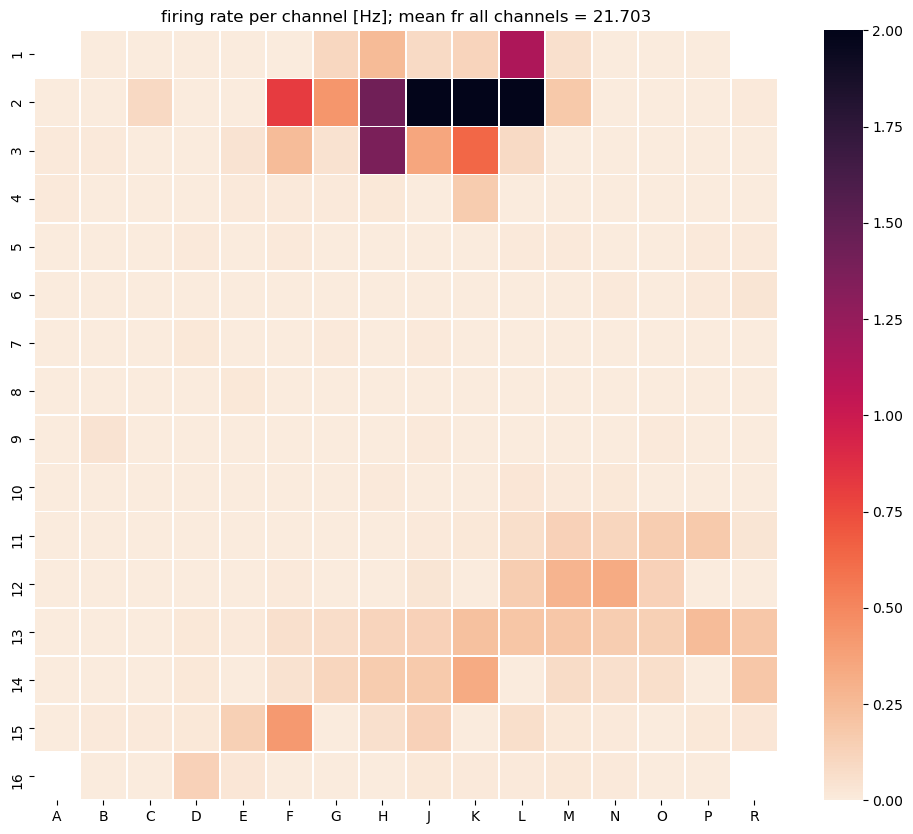

In [27]:

'''

Calculate Connected Channels depending on the

'''
# binned spiking dic
dic = bin_spike_dictionary(spike_dic_sec = spikedic_seconds,
                    bin_length_ms = 200,
                   recording_length_sec = timelengthrecording_s)

# calculate the connections
connections, cs = find_shared_spiking_activity(binned_spikedic=dic)


'''
MEA Coordinates for Plotting
'''

columnlist =['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']

mea_coordinates = np.linspace(0,1,16)
mea_positional_coordinates_dic = {}

for i in all_channels:
    x_num = columnlist.index(i[0])
    x_coord = mea_coordinates[x_num]
    y_num = 17-int(i[1:]) # minus 1 since python starts counting at zero
    y_coord = 1-(mea_coordinates[-y_num])
    mea_positional_coordinates_dic[i] = [x_coord, y_coord]

'''
CREATE THE GRAPH
'''
## actual graph

connections_graph = nx.Graph()
for key in cs:
    for i in cs[key]:
        connections_graph.add_edge(key, i)

connections_graph.number_of_nodes(), connections_graph.number_of_edges()
G = connections_graph


# calculate the corrected firing rate dic
fr_dic_corrected = {}
for key in spikedic_MAD:
    number_spikes = len(spikedic_MAD[key])
    fr = number_spikes/timelengthrecording_s
    fr_dic_corrected[key] = fr


'''
ADD Graph Properties
'''
for i in G.nodes():

    try:
        node_key = i
        coordinate = mea_positional_coordinates_dic[node_key]
        G.nodes[node_key]['pos']=coordinate
        G.nodes[node_key]['firing_rate']=fr_dic_corrected[i]

        try:
            G.nodes[node_key]['degree_centrality']=nx.degree_centrality(G)[i]
        except:
            print('degree centrality failed')

        try:
            G.nodes[node_key]['betweenness_centrality']=nx.betweenness_centrality(G, k=10, endpoints = True)[i]
        except:
            print('betweennes centrality failed')

    except KeyError:
        print('channel ', node_key, ' failed')


pos = nx.get_node_attributes(G, 'pos')



'''

Calculate Graph Metrics

'''
try:
    dgc = dict(nx.degree_centrality(G))
    mean_degree_centrality = np.round(np.mean(list(dgc.values())), 4)

except:
    dgc = None
    mean_degree_centrality = None


try:
    cc = dict(nx.closeness_centrality(G))
    closeness_centrality = np.round(np.mean(list(cc.values())), 4)

except:
    dgc = None
    mean_degree_centrality = None



try:
    evc = dict(nx.eigenvector_centrality(G))
    eigenvector_centrality = np.round(np.mean(list(evc.values())), 4)
except:
    evc = None
    eigenvector_centrality = None

try:
    average_shortest_path = nx.average_shortest_path_length(G)
except:
    average_shortest_path = None



'''
PLOTTING OF THE GRAPH
'''
# degree centrality

if dgc != None:
    fig, ax = plt.subplots(1,1, figsize=(10,10))

    nx.draw_networkx_edges(
        G,
        pos, 
        alpha=0.1, 
        edge_color='#000000',
        ax=ax,
    )
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=list(dgc.keys()),
        node_size=100,
        node_color=list(dgc.values()),
        cmap=plt.cm.Reds,
        ax=ax
    )


    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    #ax.set_xticks(columnlist)
    ax.grid(ls=':')
    #plt.axis("off")
    #ax.legend(handles=layer_colors.values(), labels=layer_colors.keys())
    plt.title('Graph - '+ filename + 'mean degree centrality = '+ str(mean_degree_centrality))

    fig.savefig(os.path.join(outputdirectory, 'graph_degreenes_centrality'+filename+'_.png'), 
                dpi = 300, bbox_inches='tight')
    fig.savefig(os.path.join(outputdirectory, 'graph_degreenes_centrality'+filename+'_.eps'), 
                dpi = 300, bbox_inches='tight')

    plt.close(fig)




# eigenvector centrality

if evc != None:
    fig, ax = plt.subplots(1,1, figsize=(10,10))


    nx.draw_networkx_edges(
        G,
        pos, 
        alpha=0.1, 
        edge_color='#000000',
        ax=ax,
    )
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=list(evc.keys()),
        node_size=100,
        node_color=list(evc.values()),
        cmap=plt.cm.Reds,
        ax=ax
    )


    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    #ax.set_xticks(columnlist)
    ax.grid(ls=':')
    #plt.axis("off")
    #ax.legend(handles=layer_colors.values(), labels=layer_colors.keys())
    plt.title('Graph - '+ filename + 'mean eigenvector centrality = '+ str(eigenvector_centrality))

    fig.savefig(os.path.join(outputdirectory, 'eigenvector_centrality'+filename+'_.png'), 
                dpi = 300, bbox_inches='tight')
    fig.savefig(os.path.join(outputdirectory, 'eigenvector_centrality'+filename+'_.eps'), 
                dpi = 300, bbox_inches='tight')

    plt.close(fig)

'''
PLOTTING OF MEA GRID

'''
# next we plot this on a mea array:

mea_array=np.empty((16,16,))
mea_array[:]=np.nan
columnlist =['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']
df = pd.DataFrame(data=mea_array,columns=columnlist)
df.index+=1

df1 = pd.DataFrame(data=mea_array,columns=columnlist)
df1.index+=1

df2 = pd.DataFrame(data=mea_array,columns=columnlist)
df2.index+=1

df3 = pd.DataFrame(data=mea_array,columns=columnlist)
df3.index+=1

use_df_copy = df.copy()
use_df_copy1 = df1.copy()
use_df_copy2 = df2.copy()
use_df_copy3 = df3.copy()

df_firing_rate = get_dict_values(use_df_copy, fr_dic_corrected)

f, ax = plt.subplots(1, 1, figsize = (12,10))

sns.heatmap(df_firing_rate, annot=False, linewidths=.5, ax=ax, cmap="rocket_r", vmax=2)
ax.set_title('firing rate per channel [Hz]; mean fr all channels = ' + str(mean_fr_whole_recording))

f.savefig(os.path.join(outputdirectory, filename+'whole_MEA_Heatmap.png'), dpi = 300, bbox_inches='tight')
f.savefig(os.path.join(outputdirectory, filename+'whole_MEA_Heatmap.eps'), dpi = 300, bbox_inches='tight')
plt.close(fig)



'''
Create DF for the Recording

'''

MDF_dic = {}
MDF_dic['filename'] = filename
MDF_dic['slice_id'] = Infos_Recording['slice_id']
MDF_dic['recording_date'] = Infos_Recording['recording_date']
MDF_dic['tissue'] = Infos_Recording['tissue']
MDF_dic['medium'] = Infos_Recording['medium']
MDF_dic['drug'] = Infos_Recording['drug']
MDF_dic['stimulation'] = Infos_Recording['stimulation']
MDF_dic['sampling_frequency'] = subrec_infos['sampling_frequency']
MDF_dic['timelength_recording_seconds'] = timelengthrecording_s
MDF_dic['active_channels'] = active_channels
MDF_dic['mean_fr_whole_recording'] = mean_fr_whole_recording
MDF_dic['mean_degree_centrality'] = mean_degree_centrality
MDF_dic['closeness_centrality'] = closeness_centrality
MDF_dic['mean_eigenvector_centrality'] = eigenvector_centrality
MDF_dic['average_shortest_path_length'] = average_shortest_path



In [29]:
all_layers

['tumor_nah', 'tumor_fern']

In [30]:
# add spikes per layer

for i in all_layers:
    MDF_dic[str('number_of_spikes_' + i)] = spikes_per_layer_dic[i]
    MDF_dic[str('fr_' + i)] = spikes_per_layer_dic[i]/timelengthrecording_s


In [31]:
dgc_per_layerdic = {}
btwc_per_layerdic = {}  

for key in layerdic:
    dgc_sum = 0
    btwc_sum = 0
    count = 0
    
    for i in layerdic[key]:
        try:
            dgc = G.nodes[i]['degree_centrality']
            dgc_sum += dgc
            count += 1
            
            btwc = G.nodes[i]['betweenness_centrality']
            btwc_sum += btwc
            count +=1
        except:
            pass
    if count == 0:
        dgc_per_layerdic[key] = count
        btwc_per_layerdic[key] = count
    else:
        dgc_per_layerdic[key] = dgc_sum / count
        btwc_per_layerdic[key] = btwc_sum / count

In [32]:
# add spikes per layer

for i in all_layers:
    MDF_dic[str('degree_centrality_' + i)] = dgc_per_layerdic[i]
    MDF_dic[str('betweenness_centrality_' + i)] = btwc_per_layerdic[i]

In [33]:
filename

'2021-05-17_cortex_div11_aCSF_ID046_30µMNE_spont_1'

In [34]:
recording_df = pd.DataFrame(MDF_dic, index=[0])
df_list.append(recording_df)
        
        
MAINDATAFRAME = pd.concat(df_list, ignore_index=True)
        
os.chdir(mainoutputdirectory)
MAINDATAFRAME.to_excel(filename + '_graph_perlayer.xlsx')
MAINDATAFRAME.to_csv(filename +'_graph_perlayer.csv')

In [35]:
len(df_list)

2